In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
import re
from nltk.tokenize import WordPunctTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_folder = './twitter-datasets/'
# data_folder = './'

# Reading the data
positive_path = os.path.join(data_folder, 'train_pos.txt')
negative_path = os.path.join(data_folder, 'train_neg.txt')

# positive_path = os.path.join(data_folder,'train_pos_full.txt')
# negative_path = os.path.join(data_folder,'train_neg_full.txt')

In [3]:
lines_positive = [line.rstrip('\n') for line in open(positive_path)]
lines_negative = [line.rstrip('\n') for line in open(negative_path)]

# Data preparation

## Create DF

In [4]:
# Create dataFrame from positive tweets and give them value 1 as a sentiment
data_pos = pd.DataFrame({
    "tweets": lines_positive,
    "sentiment": np.ones(len(lines_positive))
})

# Create dataFrame from negative tweets and give them value 0 as a sentiment
data_neg = pd.DataFrame({
    "tweets": lines_negative,
    "sentiment": np.zeros(len(lines_negative))
})
# Concat both of them
data = pd.concat([data_pos, data_neg],
                 axis=0).reset_index().drop(columns=['index'])

# Shuffle everything so that we don't have all the positives in one cluster and all the negatives in another
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,tweets,sentiment
0,heyy this fat ass is eating mc donnalds in a f...,1.0
1,<user> i guess i underestimated u too . ur blo...,1.0
2,<user> i wanna go see it,0.0
3,hi <user> it's my birthday today and my only w...,1.0
4,sailor jerry's tattoo stencils ii ( paperback ...,0.0


# Part 1 Data Cleaning

## Data Exploration

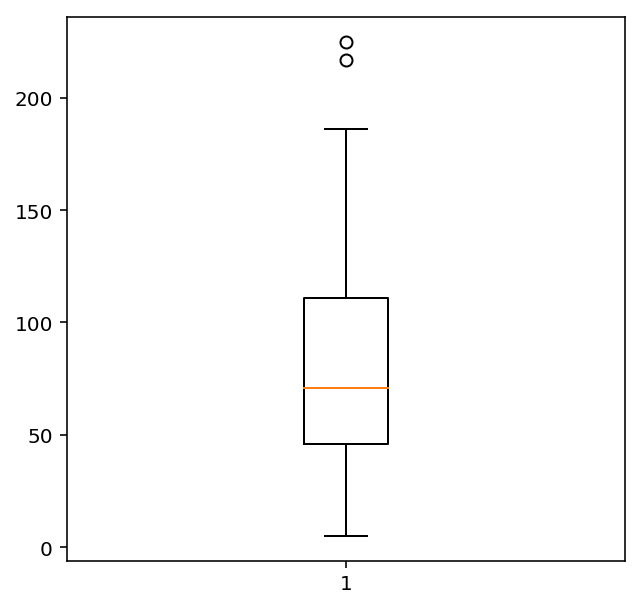

In [5]:
data['pre_clean_len'] = [len(t) for t in data.tweets]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.pre_clean_len)
plt.show()

In [6]:
tok = WordPunctTokenizer()

negations_dic = {
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "can not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not"
}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')


def tweet_cleaner(text):
    #     remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    lower_case = text.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()],
                                  lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [7]:
data['tweets'].replace(
    regex=True, inplace=True, to_replace=r'<.*?>', value=r'')
data['tweets'] = data['tweets'].apply(lambda x: tweet_cleaner(x))

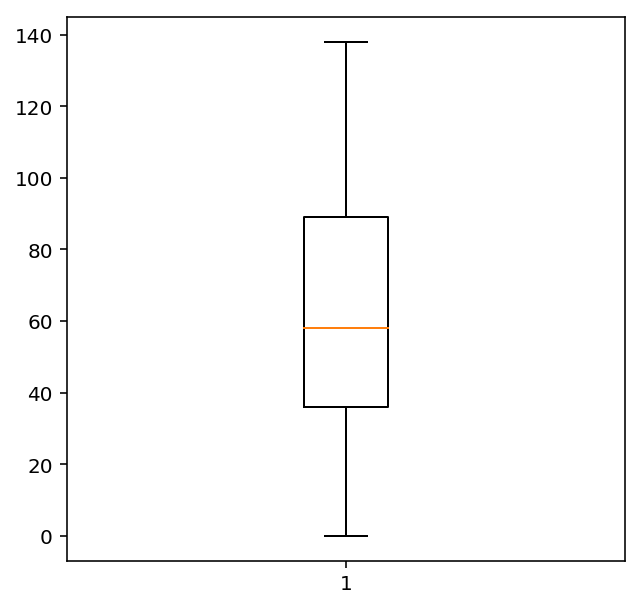

In [8]:
data['post_clean_len'] = [len(t) for t in data.tweets]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.post_clean_len)
plt.show()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(data.tweets)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [10]:
neg_doc_matrix = cvec.transform(data[data.sentiment == 0].tweets)
pos_doc_matrix = cvec.transform(data[data.sentiment == 1].tweets)
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg, pos],
                            columns=cvec.get_feature_names()).transpose()
term_freq_df.columns = ['neg', 'pos']

In [11]:
term_freq_df['total'] = term_freq_df['neg'] + term_freq_df['pos']
term_freq_df = term_freq_df.sort_values(by='total', ascending=False)
term_freq_df.head()

,neg,pos,total
the,34799,25748,60547
to,28638,27421,56059
you,17620,34374,51994
and,19125,17045,36170
my,15749,16126,31875


Text(0.5,1,'Top 500 tokens in tweets')

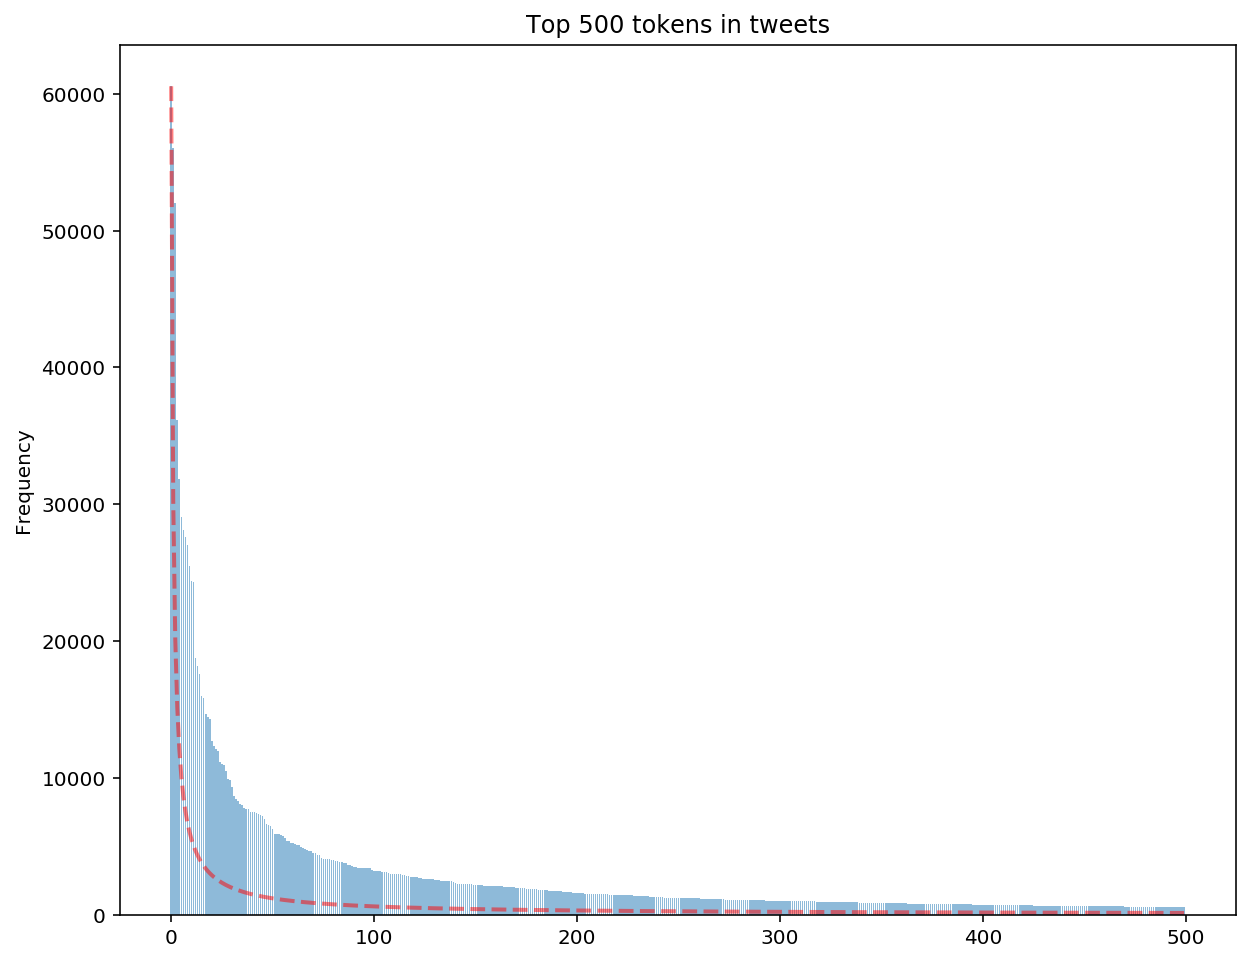

In [12]:
y_pos = np.arange(500)
plt.figure(figsize=(10, 8))
s = 1
expected_zipf = [
    term_freq_df.sort_values(by='total', ascending=False)['total'][0] / (i + 1)
    **s for i in y_pos
]
plt.bar(
    y_pos,
    term_freq_df.sort_values(by='total', ascending=False)['total'][:500],
    align='center',
    alpha=0.5)
plt.plot(
    y_pos, expected_zipf, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

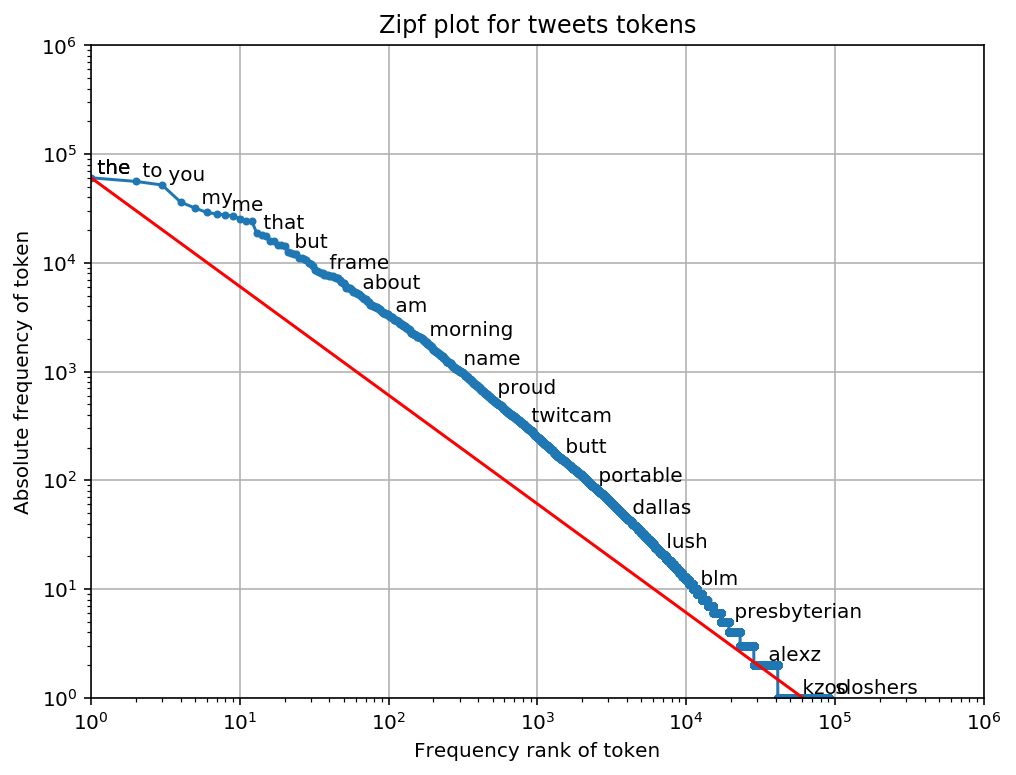

In [13]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts) + 1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8, 6))
plt.ylim(1, 10**6)
plt.xlim(1, 10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1, frequencies[0]], [frequencies[0], 1], color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts) - 2), 25).astype(int)):
    dummy = text(
        ranks[n],
        frequencies[n],
        " " + tokens[indices[n]],
        verticalalignment="bottom",
        horizontalalignment="left")

## Removing Stop words

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english', max_features=10000)
cvec.fit(data.tweets)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [15]:
document_matrix = cvec.transform(data.tweets)

In [16]:
neg_doc_matrix = cvec.transform(data[data.sentiment == 0].tweets)
pos_doc_matrix = cvec.transform(data[data.sentiment == 1].tweets)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['neg','pos']
term_freq_df2['total'] = term_freq_df2['neg'] + term_freq_df2['pos']
term_freq_df2 = term_freq_df2.sort_values(by='total', ascending=False)
term_freq_df2.head()

,neg,pos,total
just,5892,6453,12345
rt,4722,7418,12140
love,2602,8585,11187
like,4211,5083,9294
frame,7974,11,7985


## Part 3

Text(0.5,1,'Top 50 tokens in negative tweets')

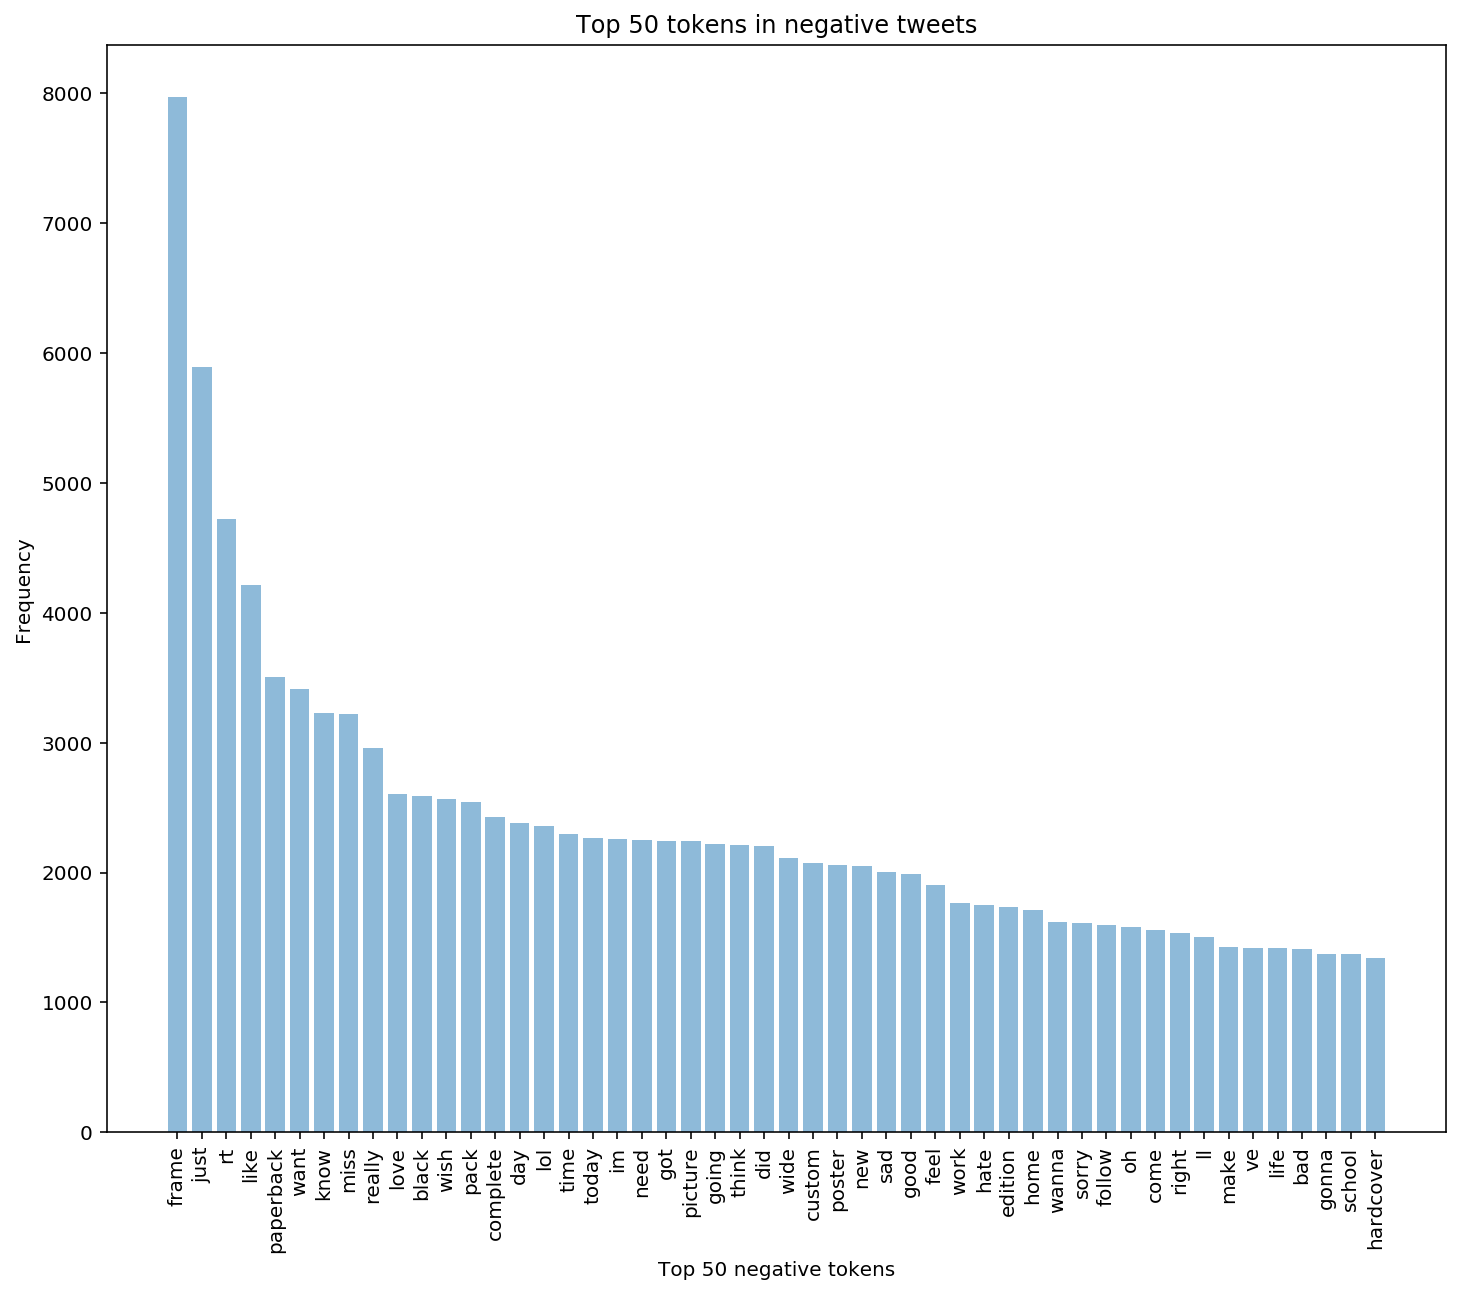

In [17]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='neg', ascending=False)['neg'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='neg', ascending=False)['neg'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5,1,'Top 50 tokens in positive tweets')

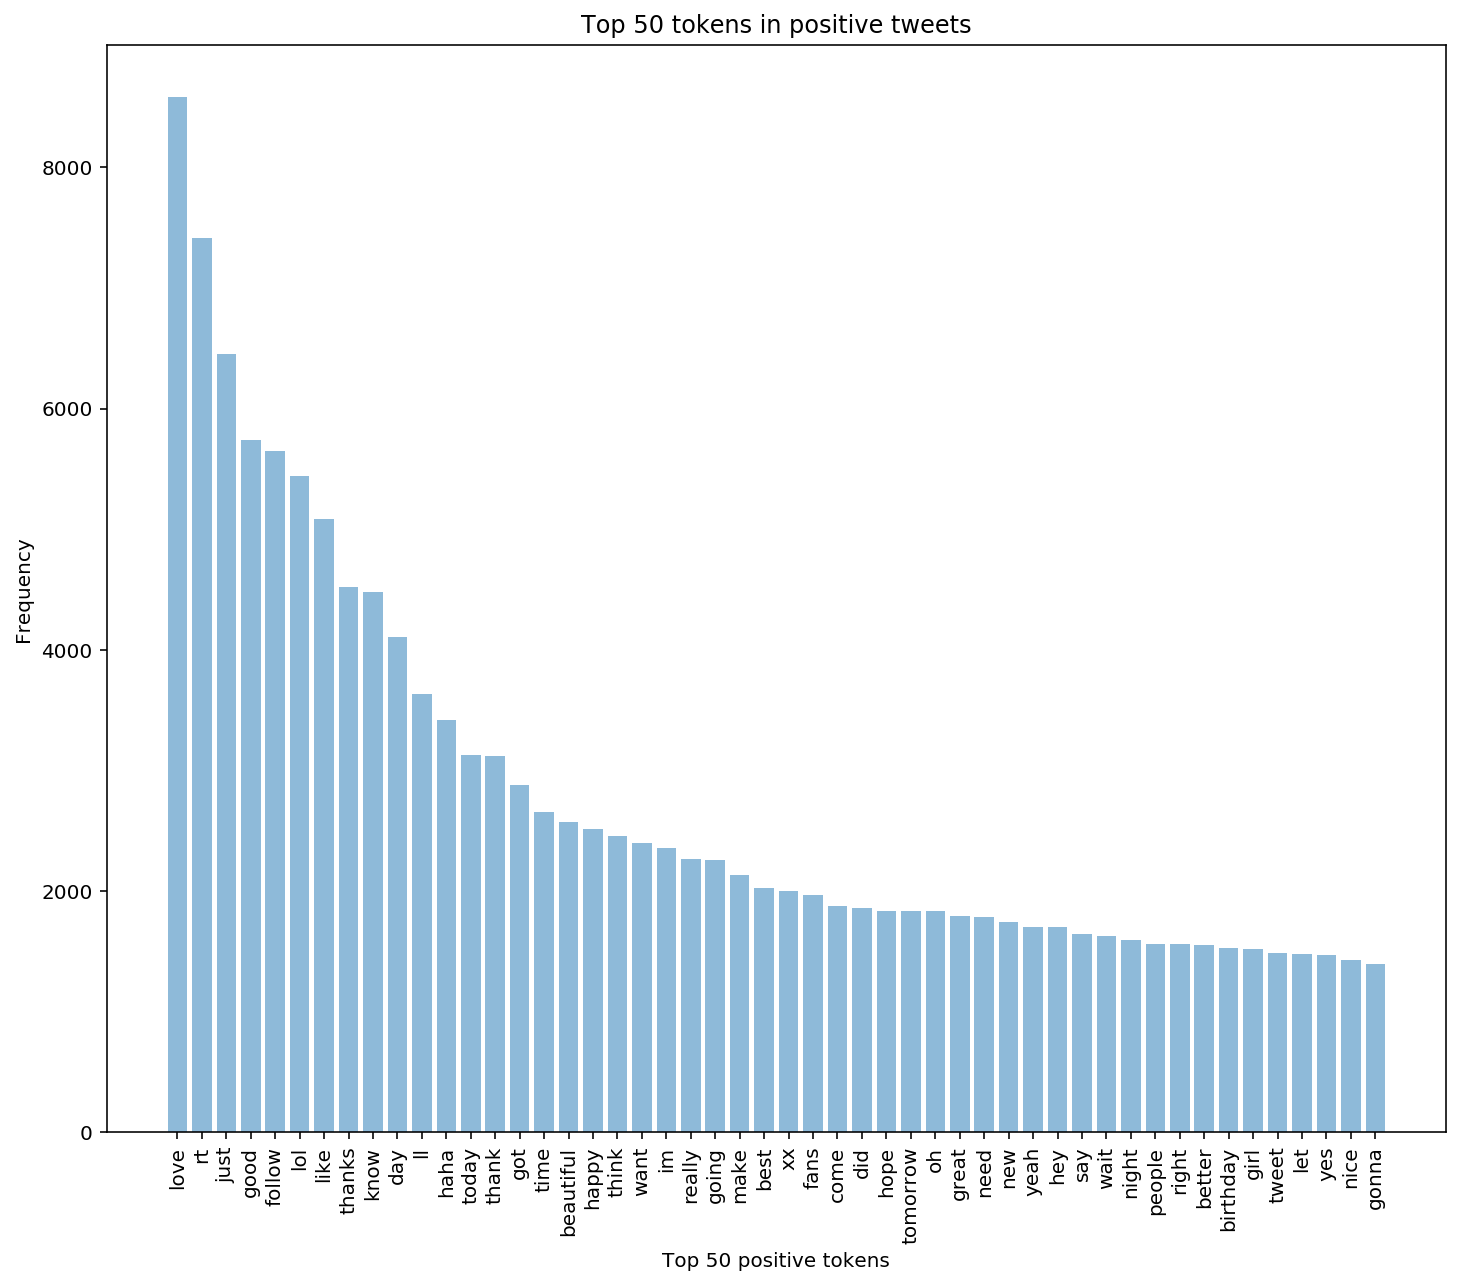

In [18]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='pos', ascending=False)['pos'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='pos', ascending=False)['pos'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5,1,'Negative Frequency vs Positive Frequency')

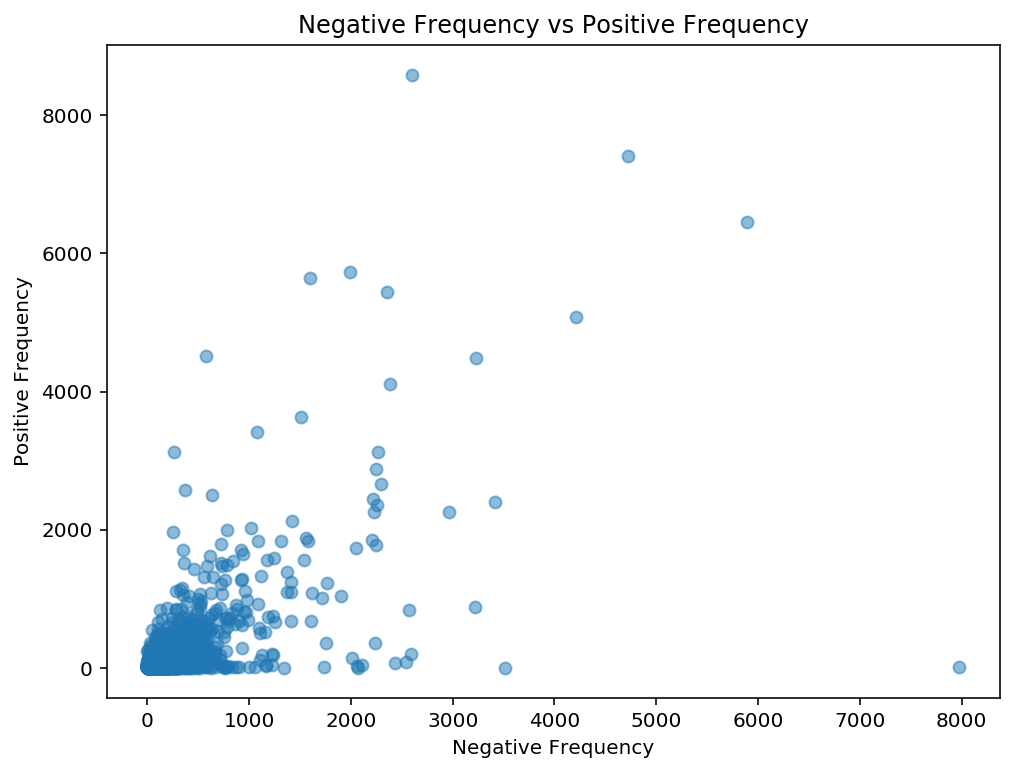

In [19]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg", y="pos",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

we cannot see meaningful relations between negative and positive frequency.

In [20]:
term_freq_df2['pos_rate'] = term_freq_df2['pos'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,neg,pos,total,pos_rate
honesthour,0,12,12,1.0
ifindthatattractive,0,50,50,1.0
ziall,0,17,17,1.0
unpopular,0,50,50,1.0
twfanmily,0,23,23,1.0
thanking,0,27,27,1.0
askjessiej,0,13,13,1.0
fanbook,0,16,16,1.0
okey,0,18,18,1.0
youcangetmajorpointsif,0,29,29,1.0


pos_freq_pct is just the frequency scaled over the total sum of the frequency, the rank of pos_freq_pct is exactly same as just the positive frequency.

In [21]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['pos'] * 1./term_freq_df2['pos'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,neg,pos,total,pos_rate,pos_freq_pct
love,2602,8585,11187,0.767409,0.017101
rt,4722,7418,12140,0.611038,0.014777
just,5892,6453,12345,0.522722,0.012854
good,1987,5737,7724,0.742750,0.011428
follow,1596,5649,7245,0.779710,0.011253
lol,2358,5440,7798,0.697615,0.010836
like,4211,5083,9294,0.546912,0.010125
thanks,577,4517,5094,0.886729,0.008998
know,3229,4480,7709,0.581139,0.008924
day,2379,4106,6485,0.633153,0.008179


Using the harmonic mean on pos_freq_pct

In [22]:
from scipy.stats import hmean
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])                                                               if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,neg,pos,total,pos_rate,pos_freq_pct,pos_hmean
love,2602,8585,11187,0.767409,0.017101,0.033457
rt,4722,7418,12140,0.611038,0.014777,0.028855
just,5892,6453,12345,0.522722,0.012854,0.025092
good,1987,5737,7724,0.742750,0.011428,0.022510
follow,1596,5649,7245,0.779710,0.011253,0.022185
lol,2358,5440,7798,0.697615,0.010836,0.021341
like,4211,5083,9294,0.546912,0.010125,0.019882
thanks,577,4517,5094,0.886729,0.008998,0.017815
know,3229,4480,7709,0.581139,0.008924,0.017578
day,2379,4106,6485,0.633153,0.008179,0.016150


In [23]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

,neg,pos,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
thank,261,3119,3380,0.922781,0.006213,0.012343,0.990168,1.000000,0.995060
fans,248,1968,2216,0.888087,0.003920,0.007806,0.985765,1.000000,0.992832
thanks,577,4517,5094,0.886729,0.008998,0.017815,0.985563,1.000000,0.992729
beautiful,372,2572,2944,0.873641,0.005123,0.010187,0.983482,1.000000,0.991672
smile,125,838,963,0.870197,0.001669,0.003332,0.982894,0.999242,0.991000
glad,101,660,761,0.867280,0.001315,0.002625,0.982382,0.992953,0.987639
hey,353,1703,2056,0.828307,0.003392,0.006757,0.974184,1.000000,0.986923
excited,146,708,854,0.829040,0.001410,0.002816,0.974363,0.995952,0.985040
awesome,196,867,1063,0.815616,0.001727,0.003447,0.970905,0.999496,0.984993
birthday,358,1526,1884,0.809979,0.003040,0.006057,0.969342,1.000000,0.984432


In [24]:
term_freq_df2['neg_rate'] = term_freq_df2['neg'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['neg'] * 1./term_freq_df2['neg'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,neg,pos,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
hardcover,1342,0,1342,0.000000,0.000000,0.000000,0.074584,0.419922,0.126670,1.000000,0.002054,0.004100,0.925416,1.000000,0.961263
paperback,3509,2,3511,0.000570,0.000004,0.000008,0.074913,0.423072,0.127287,0.999430,0.005372,0.010686,0.925087,1.000000,0.961086
frame,7974,11,7985,0.001378,0.000022,0.000043,0.075382,0.437303,0.128596,0.998622,0.012207,0.024119,0.924618,1.000000,0.960833
custom,2074,6,2080,0.002885,0.000012,0.000024,0.076262,0.429386,0.129520,0.997115,0.003175,0.006330,0.923738,1.000000,0.960358
ounce,761,4,765,0.005229,0.000008,0.000016,0.077646,0.426226,0.131362,0.994771,0.001165,0.002327,0.922354,0.999427,0.959345
replacement,625,1,626,0.001597,0.000002,0.000004,0.075510,0.421496,0.128075,0.998403,0.000957,0.001912,0.924490,0.995553,0.958707
gb,905,9,914,0.009847,0.000018,0.000036,0.080429,0.434133,0.135715,0.990153,0.001385,0.002767,0.919571,0.999957,0.958081
edition,1738,19,1757,0.010814,0.000038,0.000075,0.081021,0.450022,0.137319,0.989186,0.002661,0.005307,0.918979,1.000000,0.957779
wood,1053,12,1065,0.011268,0.000024,0.000048,0.081300,0.438890,0.137187,0.988732,0.001612,0.003219,0.918700,0.999998,0.957627
audio,998,12,1010,0.011881,0.000024,0.000048,0.081678,0.438890,0.137726,0.988119,0.001528,0.003051,0.918322,0.999993,0.957419


Text(0.5,1,'neg_hmean vs pos_hmean')

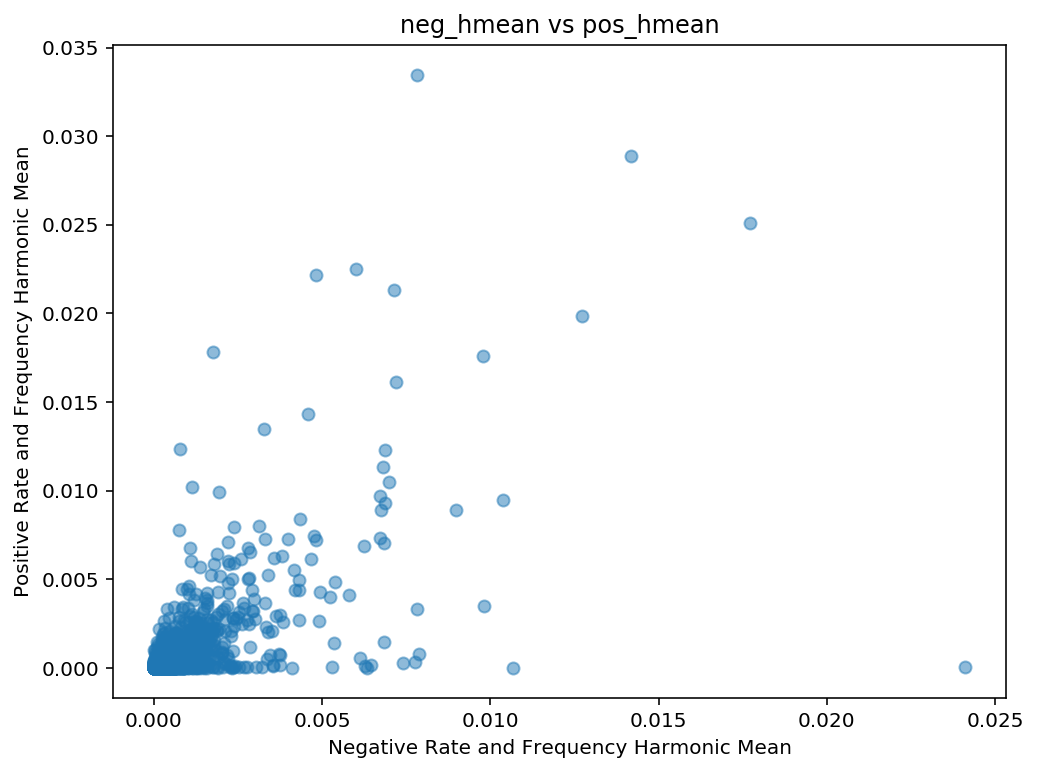

In [25]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5,1,'neg_normcdf_hmean vs pos_normcdf_hmean')

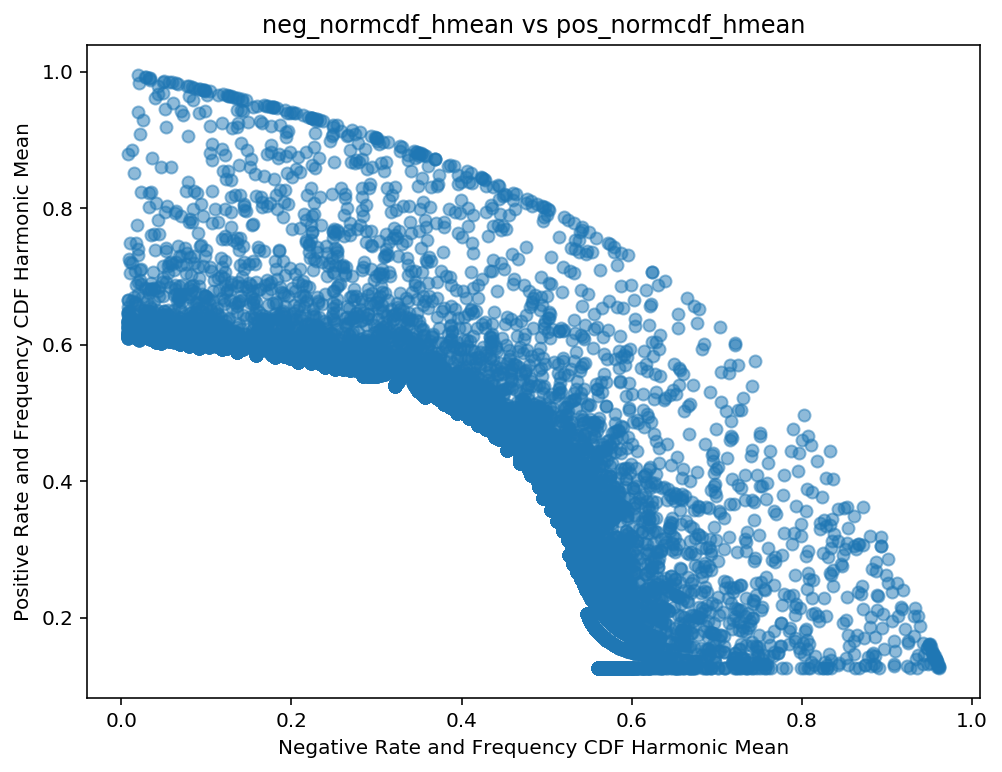

In [26]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [27]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

## Part 4: Count vectorizer, confusion matrix

### Importance of Stop Words

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from time import time

In [34]:
x = data.tweets
y = data.sentiment
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == 0]) / (len(x_train)*1.))*100, (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation), (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100, (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 196000 entries with 49.99% negative, 50.01% positive
Validation set has total 2000 entries with 50.95% negative, 49.05% positive
Test set has total 2000 entries with 50.45% negative, 49.55% positive


In [48]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):

    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time


cvec = CountVectorizer()
lr = LogisticRegression()

# Number of words used from the dictionary by the CountVectorizer
n_features = np.arange(10000,100001,10000)


def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [36]:
from sklearn.feature_extraction import text
a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
set(a).issubset(set(b))


True

In [39]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)


RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.95%
accuracy score: 79.15%
model is 28.20% more accurate than null accuracy
train and test time: 6.99s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.95%
accuracy score: 79.25%
model is 28.30% more accurate than null accuracy
train and test time: 6.73s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.95%
accuracy score: 78.85%
model is 27.90% more accurate than null accuracy
train and test time: 7.92s
----------------------------------------------------------

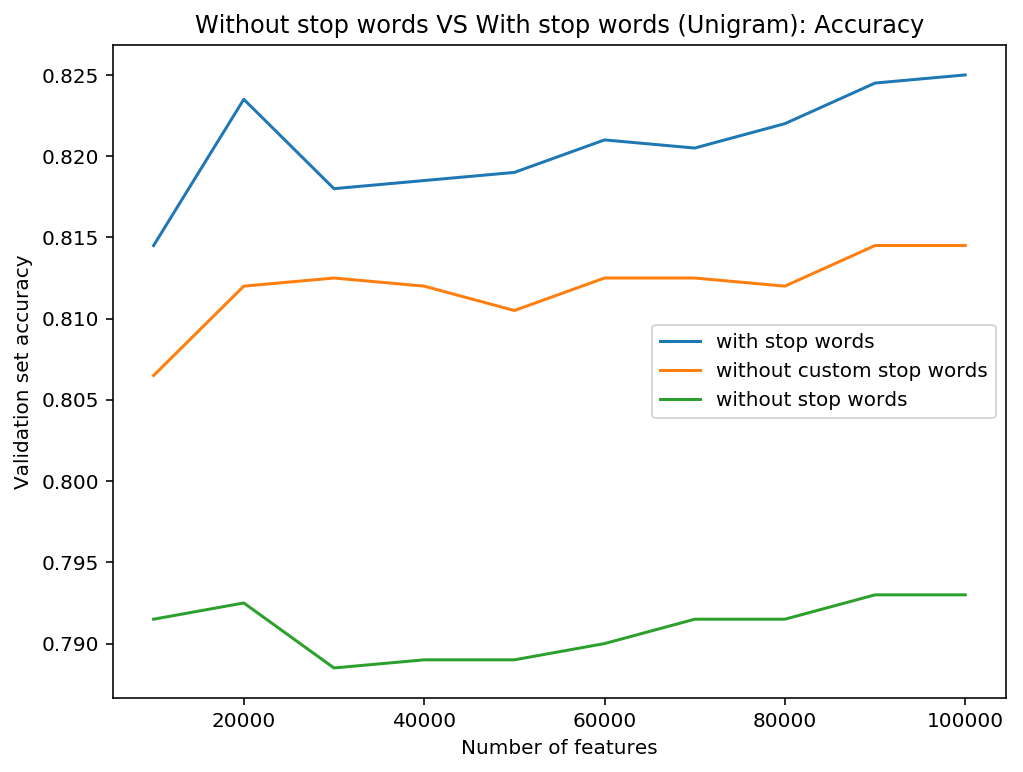

In [40]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

# plot
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.show()

### Which N-GRAM is best ?

In [41]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.95%
accuracy score: 82.70%
model is 31.75% more accurate than null accuracy
train and test time: 21.95s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.95%
accuracy score: 83.15%
model is 32.20% more accurate than null accuracy
train and test time: 22.25s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.95%
accuracy score: 82.60%
model is 31.65% more accurate than null accuracy
train and test time: 24.81s
-----------------------------------------------------------

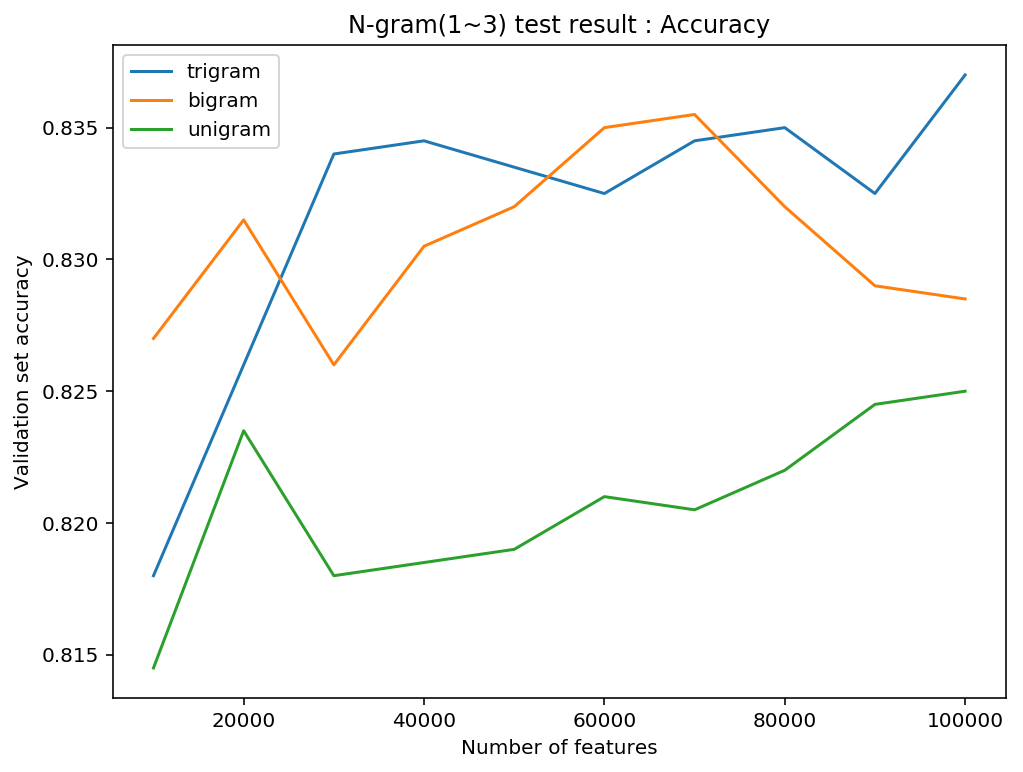

In [42]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.show()

In [44]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print (confusion)
    print ("-"*80)
    print ("Classification Report\n")
    print (classification_report(y_test, y_pred, target_names=['negative','positive']))

In [47]:
%%time

#Best Model so far 
tg_cvec = CountVectorizer(max_features=100000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

accuracy score: 83.70%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 822                 197
positive                 129                 852
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.86      0.81      0.83      1019
   positive       0.81      0.87      0.84       981

avg / total       0.84      0.84      0.84      2000

CPU times: user 49.4 s, sys: 2.93 s, total: 52.3 s
Wall time: 1min 8s


## Part 5: Tfidf vectorizer, model comparison, lexical approach

### Tfidf vs Count Vectorizer

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
accuracy score: 80.80%
train and test time: 5.92s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 81.25%
train and test time: 5.19s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 81.20%
train and test time: 5.79s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 81.10%
train and test time: 7.43s
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 81.25%
t

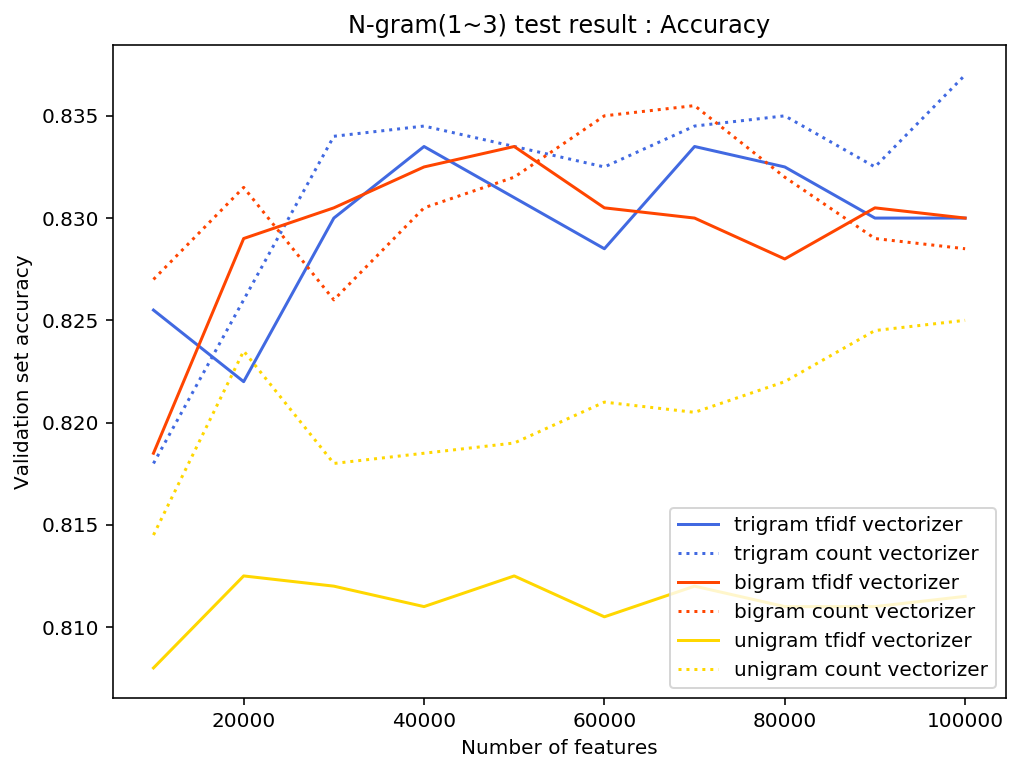

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))


In [ ]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

### Testing Multiple Algorithms

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy score: 83.00%
train and test time: 33.51s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
accuracy score: 83.25%
train and test time: 28.19s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,